<a href="https://colab.research.google.com/github/SethCram/CS474-Deep-Learning/blob/main/HW4/HW4_CNN_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [11]:
import tensorflow as tf
import keras 
from keras import layers
from keras import optimizers
from keras import applications
from keras import losses
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import os
import csv

## Colab

In [ ]:
## Google Colab Cell

#enable debugging
!pip install -Uqq ipdb
import ipdb
%pdb on

#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/School/Senior Year/CS 474-01 (Deep Learning)/

# Data Import
## LOAD CSV AND IMAGES

      Unnamed: 0         img name  tumor types
0              0           000137            1
1              1         case0419            1
2              2         case0024            0
3              3     benign (397)            0
4              4         case0287            0
...          ...              ...          ...
2379        2379  malignant (143)            1
2380        2380         case0441            1
2381        2381     benign (162)            0
2382        2382           000064            0
2383        2383           000022            0

[2384 rows x 3 columns]


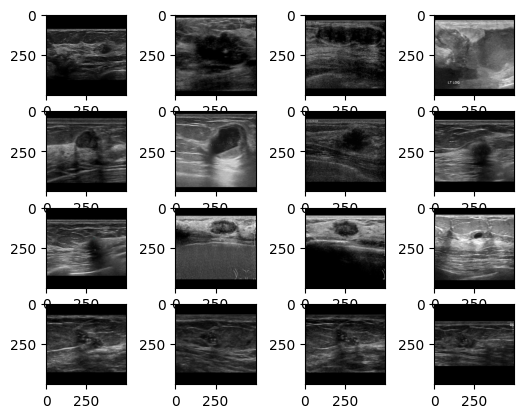

In [2]:
#LOAD CSV AND IMAGES (in proper resolution)

df=pd.read_csv('https://raw.githubusercontent.com/SethCram/CS474-Deep-Learning/main/HW4/train.csv', sep = ',')
print(df)

training_imgs_path = 'trainImgs/'
test_imgs_path = 'testImgs/'

targetWidth = 600
targetHeight = 600

# store training and test imgs greyscaled 
x_train = np.array([
            cv.resize( #resize to desired size
                cv.imread(training_imgs_path + row[1] + ".png"), 
                dsize=(targetWidth, targetHeight),
            ) 
            for row in df.values
        ]
    )
x_test = np.array([
        cv.resize( #resize to desired size
            cv.imread(test_imgs_path + str(i) + ".png"),
            dsize=(targetWidth, targetHeight),
        )
        for i in range(1248)]
    )

#store whether benign (0?) or malignant (1?)
y_train = np.array([row[2] for row in df.values], dtype='float32')

nImg = 4  
for i in range(nImg*nImg):
    plt.subplot(nImg, nImg, i+1)
    plt.imshow(x_train[i], cmap = 'Greys_r')
plt.show()

pass

## Load Images
ONLY RUNNABLE A SINGLE TIME PER SESSION

In [3]:
## UNUSED

#ONLY RUNNABLE A SINGLE TIME PER SESSION
def load_imgs(x_train_size, x_test_size, max_width, max_height, show_sample = True, batch_size=100):
    
    ## Data Preprocessing
    
    #need to do some sort of zero/same padding to get same image sizes
    # unless using fully convolutional NN bc can take inputs of different sizes
    # or if use a spatial pyramid pooling (SPP) layer before dense layers
    
    #Could possibly create more training data thru upscaling/downscaling
    # would better recognise diff scaled data
    # or get same size of inputs too
    
    x_train = np.empty((x_train_size, max_width, max_height, 3), dtype='float32')
    x_test = np.empty((x_test_size, max_width, max_height, 3), dtype='float32')
    
    for i, image in enumerate(x_train_diff_reses):
        #x_train_diff_reses[i] = pad_image(
        #    image, 
        #    biggest_training_width, 
        #    biggest_training_height
        #)
        
        x_train[i] = cv.copyMakeBorder(
            image, 
            0, 
            max_height-image.shape[0], 
            0, 
            max_width-image.shape[1], 
            cv.BORDER_CONSTANT
        )#/255.0 #normalize

    #x_train = np.expand_dims(x_train, -1)

    for i, image in enumerate(x_test_diff_reses):
        #x_train_diff_reses[i] = pad_image(
        #    image, 
        #    biggest_training_width, 
        #    biggest_training_height
        #)
        
        x_test[i] = cv.copyMakeBorder(
            image, 
            0, 
            max_height-image.shape[0], 
            0, 
            max_width-image.shape[1], 
            cv.BORDER_CONSTANT
        )#/255.0 #normalize

    #x_test = np.expand_dims(x_test, -1)
    
    #assert biggest_test_width == min( image.shape[0] for image in x_test_diff_reses )
    #assert biggest_test_height == min( image.shape[1] for image in x_test_diff_reses )
    
    #assert biggest_training_width == min( image.shape[0] for image in x_train_diff_reses )
    #assert biggest_training_height == min( image.shape[1] for image in x_train_diff_reses )

    #m = len(x_train_diff_reses)
    #for b in range(int(m/batch_size)):
    #    b_start= b*batch_size
    #    b_end = min((b+1)*batch_size, m)
    #    
    #    x_batch = x_train_diff_reses[b_start:b_end]
    #    x_train[b_start:b_end] = construct_image_batch(x_batch)
    
    #store whether benign (0?) or malignant (1?)
    y_train = np.array([row[2] for row in df.values], dtype='float32')
    y_test = np.zeros(x_test.shape[0], dtype='float32') #no labels on test data??
    
    #show first 100 images
    if show_sample == True:
        nImg = 4
        for i in range(nImg*nImg):
            plt.subplot(nImg, nImg, i+1)
            plt.imshow(x_train[i], cmap = 'Greys_r')
        plt.show()
        
    #x_train = np.reshape(x_train, [x_train.shape[0], x_train.shape[1] * x_train.shape[2]]) #adds 2nd dim of 1
    #x_test = np.reshape(x_test, [x_test.shape[0], x_test.shape[1] * x_test.shape[2]]) #adds 2nd dim of 1
        
    return x_train, y_train, x_test, y_test

#Get training and test max resolutions
biggest_training_width = max( image.shape[0] for image in x_train_diff_reses )
biggest_training_height = max( image.shape[1] for image in x_train_diff_reses )

biggest_test_width = max( image.shape[0] for image in x_test_diff_reses )
biggest_test_height = max( image.shape[1] for image in x_test_diff_reses )

#get max width and height of any input image
max_width = max( [biggest_test_width, biggest_training_width] )
max_height = max( [biggest_test_height, biggest_training_height] )

x_train, y_train, x_test, y_test = load_imgs(len(x_train_diff_reses), len(x_test_diff_reses), max_width, max_height,)

print('Data shape:', 'x_train:', x_train.shape, 'x_test:', x_test.shape)
print('Data shape:', 'y_train:', y_train.shape, 'y_test:', y_test.shape)


MemoryError: Unable to allocate 43.9 GiB for an array with shape (2384, 1283, 1283, 3) and data type float32

# Transfer Learning
## Model Creation

In [9]:
preprocc_input = applications.vgg16.preprocess_input

#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

input_layer = layers.Input(shape=(targetWidth, targetHeight, 3))

#img_conc = layers.Concatenate()([img_input, img_input, img_input])  

#applications.InceptionResNetV2(include_top=False)
base_model = applications.VGG16(
    input_shape=(targetWidth, targetHeight, 3),
    #input_tensor=img_conc,
    include_top=False,
)

global_average_layer = layers.GlobalAveragePooling2D()

output_layer = layers.Dense(
    units=1,
    activation='softmax'
)

base_model.trainable = False

x = preprocc_input(input_layer)

x = base_model(x, training=False)

# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

#x = global_average_layer(x)
#x = layers.Dropout(0.5)(x)

outputs = output_layer(x)

model_transfer = keras.Model(input_layer, outputs)


model_transfer.compile(
    optimizer='adam', #to deal with noise
    loss=losses.BinaryCrossentropy(), #or just categorical_crossentropy?
    metrics=['accuracy']
)

model_transfer.summary(expand_nested=True, show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_3 (InputLayer)        [(None, 500, 500, 3)]     0         Y          
                                                                            
 tf.__operators__.getitem_1   (None, 500, 500, 3)      0         Y          
 (SlicingOpLambda)                                                          
                                                                            
 tf.nn.bias_add_1 (TFOpLambd  (None, 500, 500, 3)      0         Y          
 a)                                                                         
                                                                            
 vgg16 (Functional)          (None, 15, 15, 512)       14714688  N          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_4 (InputLayer)      [(None, 500, 500, 3)]     0    

## Model Training

In [10]:
batch_size = 32

history_transfer = model_transfer.fit(
    x_train[0:500], 
    y_train[0:500],
    epochs=10, #5, 
    batch_size=batch_size,  #128, 64 crashed it; 40, 20 in both Epoch ETA is 10 mins didn't crash it
    validation_split=0.2, 
    validation_batch_size=batch_size
)

Epoch 1/10
14/14 [==============================] - 175s 13s/step - loss: 17.4341 - accuracy: 0.5075 - val_loss: 8.3180 - val_accuracy: 0.5500
Epoch 2/10
14/14 [==============================] - 168s 12s/step - loss: 3.4973 - accuracy: 0.5075 - val_loss: 4.7105 - val_accuracy: 0.5500
Epoch 3/10
14/14 [==============================] - 162s 12s/step - loss: 0.5742 - accuracy: 0.5075 - val_loss: 6.1156 - val_accuracy: 0.5500
Epoch 4/10
14/14 [==============================] - 162s 12s/step - loss: 0.2144 - accuracy: 0.5075 - val_loss: 5.0718 - val_accuracy: 0.5500
Epoch 5/10
14/14 [==============================] - 163s 12s/step - loss: 0.0090 - accuracy: 0.5075 - val_loss: 5.1377 - val_accuracy: 0.5500
Epoch 6/10
14/14 [==============================] - 164s 12s/step - loss: 0.0041 - accuracy: 0.5075 - val_loss: 5.1308 - val_accuracy: 0.5500
Epoch 7/10
14/14 [==============================] - 161s 12s/step - loss: 3.6561e-05 - accuracy: 0.5075 - val_loss: 5.7987 - val_accuracy: 0.5500
E

# CNN Model
## Model Creation

In [ ]:
#CNN MODEL

model_CNN = keras.Sequential()

input_layer = layers.Input(
    shape=(max_width, max_height, 1),
)
model_CNN.add(input_layer)

conv_1_layer = layers.Conv2D(
        filters=64,
        kernel_size=3,
        activation='relu'
    )
model_CNN.add(conv_1_layer)

conv_2_layer = layers.Conv2D(
        filters=32,
        kernel_size=3,
        activation='relu'
    )
model_CNN.add(conv_2_layer)

conv_3_layer = layers.Conv2D(
        filters=16,
        kernel_size=3,
        activation='relu'
    )
model_CNN.add(conv_3_layer)

flatten_layer = layers.Flatten()
model_CNN.add(flatten_layer)

output_layer = layers.Dense(1, activation='softmax')
model_CNN.add(output_layer)

model_CNN.compile(
    optimizer='adam', #to deal with noise
    loss=losses.BinaryCrossentropy(), #or just categorical_crossentropy?
    metrics=['accuracy']
)

model_CNN.summary()

## CNN Model Training

In [ ]:
#TRAIN CNN MODEL

batch_size = 5 #1 epoch ETA = 2:15:00, 2 epoch ETA = 1:53:00, 3, 4, 5 epoch ETA = 1:30:00 epoch works; 6, 10, 64 doesn't work bc OOM

#for debugging, could train with subset of overall data
# could do 100 train images and less test images
# resulted in epoch run time of 3 minutes = 100, 80
# fastest of 20s per epoch = 10, 10
#x_train = x_train[0:10]
#y_train = y_train[0:10]
#x_test = x_test[0:10]
#y_test = y_test[0:10]

history_CNN = model_CNN.fit(
    x_train, 
    y_train,
    epochs=2, #5, 
    batch_size=batch_size,  
    validation_split=0.2, 
    validation_batch_size=batch_size
)

## Save/Restore Model

In [ ]:
## SAVE THE MODEL

model_CNN.save("saved_models/cnn_undertrained_model")

In [ ]:
## RESTORE THE MODEL

model_CNN = keras.models.load_model("saved_models/cnn_undertrained_model")

model_CNN.summary()

# Fully Conv NN (FCN)
## Model Creation

In [ ]:
# FULLY CONVOLUTION NN (FCN)

def construct_image_batch(image_group, BATCH_SIZE):
    # get the max image shape
    max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(3))

    # construct an image batch object
    image_batch = np.zeros((BATCH_SIZE,) + max_shape, dtype='float32')

    # copy all images to the upper left part of the image batch object
    for image_index, image in enumerate(image_group):
        image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

    return image_batch

classes = 2

# Input layer
input = layers.Input(shape=(231, 231, 1)) #test with smallest input shape to determine # of conv blocks?

# input convolution block
x = layers.Conv2D(filters=128, kernel_size=3, strides=1)(input)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# middle convolution block
#x = layers.Conv2D(filters=64, kernel_size=3, strides=1)(x)
#x = layers.Dropout(0.2)(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)

# middle convolution block
#x = layers.Conv2D(filters=32, kernel_size=3, strides=1)(x)
#x = layers.Dropout(0.2)(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)

# final convolution block
x = layers.Conv2D(filters=classes, kernel_size=1, strides=1)(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalMaxPooling2D()(x)
predictions = layers.Activation('relu')(x)

model = keras.Model(inputs=input, outputs=predictions)
model.summary()

## Model Training

In [ ]:
# TRAIN FCN

def train(model, train_generator, val_generator, epochs = 50):
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    checkpoint_path = './snapshots'
    os.makedirs(checkpoint_path, exist_ok=True)
    model_path = os.path.join(checkpoint_path, 'model_epoch_{epoch:02d}_loss_{loss:.2f}_acc_{acc:.2f}_val_loss_{val_loss:.2f}_val_acc_{val_acc:.2f}.h5')
    
    history = model.fit_generator(generator=train_generator,
            steps_per_epoch=len(train_generator),
            epochs=epochs,
            callbacks=[keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)],
            validation_data=val_generator,
            validation_steps=len(val_generator)
        )

    return history

#train model
history = model_fcn.fit(
    x_train, #should be 2d inputs
    y_train, #already onehot
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_split=0.2,
)

# Model Evaluation
## Prediction

In [19]:
## Model Prediction

batch_size = 32

model = model_transfer

#test prediction storage
y_test_pred = model.predict(x_test[0:100], batch_size=batch_size).flatten()

with open('HW4_predictions_SethCram.csv', 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    
    for i in range(len(y_test_pred)):
        writer.writerow([str(i) + ".png", y_test_pred[i]])
        
        
#train accuracy
y_train_pred = model.predict(x_train[0:100], batch_size=batch_size).flatten()

train_acc = np.sum(y_train == y_train_pred) / y_train.shape[0]

print(f'train accuracy: {train_acc * 100}')

1/4 [======>.......................] - ETA: 32s

KeyboardInterrupt: 

## Accuracy

In [ ]:
#history of training and validation accuracy (only works if model trained and not preloaded)
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
plt.legend(['training acc', 'validation acc'])
plt.show()

# Unused Cells

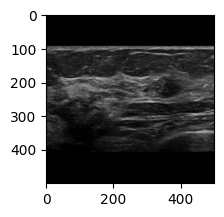

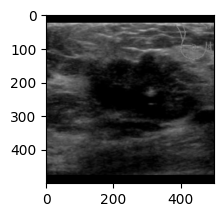

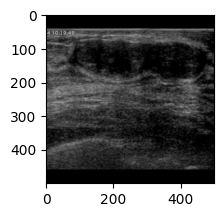

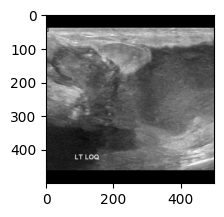

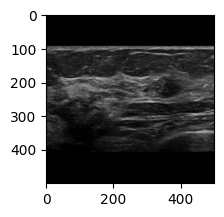

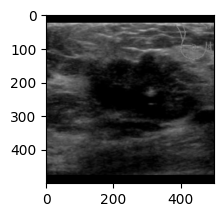

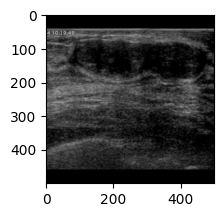

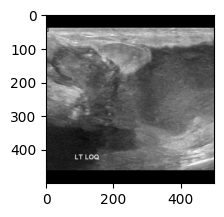

In [21]:
## UNUSED

targetWidth = 500
targetHeight = 500

def resize(x, targetWidth, targetHeight):
    
    nImg = 2
    
    for i in range(nImg*nImg):
        plt.subplot(nImg, nImg, i+1)
        plt.imshow(x[i], cmap = 'Greys_r')
    plt.show()
    
    for i,img in enumerate(x):
        x[i] = cv.resize(img, dsize=(targetWidth, targetHeight))
        
    for i in range(nImg*nImg):
        plt.subplot(nImg, nImg, i+1)
        plt.imshow(x[i], cmap = 'Greys_r')
    plt.show()
        
    return x

resize(x_train, targetWidth, targetHeight)


In [ ]:
#get access to filters/kernels
weights = convLayers[0].get_weights()[0][:, :, 0, :] #arr of a buncha nested lists, 0 bc only have 1 channel (28, 28, 1, 8)

#can get access to other params this way 

for i in range(1, 8):
    plt.subplot(2, 4, i)
    plt.imshow(weights[:,:,i], cmap="gray")
plt.show()

#how get access to feature maps?

In [ ]:
# UNUSED

#preprocess_input = keras.applications.mobilenet_v2.preprocess_input

## load the cancer dataset
def construct_image_batch(image_group):
    
    # get the max image shape
    max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(2))

    # construct an image batch object
    image_batch = np.zeros((len(image_group),) + max_shape, dtype='float32')

    # copy all images to the upper left part of the image batch object
    for image_index, image in enumerate(image_group):
        image_batch[image_index, :image.shape[0], :image.shape[1]] = image

    return image_batch

def pad_image(image, maxX, maxY):
    #apply zero padding to smaller images
    zero_image = np.zeros(
        (maxX, maxY),
         dtype='float32'
    )
    # copy image to the upper left part of zero image
    zero_image[:image.shape[0], :image.shape[1]] = image
    
    return zero_image

In [ ]:
# UNUSED 

# expand dims for channels?

#model = applications.resnet_v2.ResNet101V2(
#    include_top=False,
#    weights='imagenet',
#    input_tensor=x_train,
#    input_shape=x_train.shape,
#    pooling=None,
#    classes=1,
#    classifier_activation='softmax'
#)

desiredLevels = 2

def CreateConvLayer(convLayers, model, filters, kernel_size, activation = None, padding = "valid"):
    conv = layers.Conv2D(
        filters= filters, #num of filters for conv
        kernel_size = kernel_size, 
        padding = padding,
        activation = activation,
        #input_shape = (28, 28, 1) #only 28 params 
    )
    
    convLayers.append(conv)
    model.add(conv)
    
def CreateMaxPoolLayer(poolLayers, model, pool_size, strides):
    pool = layers.MaxPooling2D(
        pool_size = pool_size,
        strides = strides,
    )
    
    poolLayers.append(pool)
    model.add(pool)
    
def CreateConvBlock(
    model, convLayers, poolLayers, normLayers, activationLayers,
    filters, kernel_size, activation,
    pool_size, strides
):
    CreateConvLayer(convLayers, model, filters, kernel_size)
    #CreateMaxPoolLayer(poolLayers, model, pool_size, strides)
    
    dropout = layers.Dropout(0.2)
    model.add(dropout)
    
    norm = layers.BatchNormalization()
    model.add(norm)
    normLayers.append(norm)

    activ = layers.Activation(activation)
    model.add(activ)
    activationLayers.append(activ)
    
# Create a fully conv NN
model_fcn = keras.Sequential()

convLayers = []
poolLayers = []
normLayers = []
activationLayers = []

# Input layer
input = layers.Input(shape=(None, None, 1))
model_fcn.add(input)

CreateConvBlock(
    model_fcn, convLayers, poolLayers, normLayers, activationLayers,
    filters=8, kernel_size=3, activation='relu',
    pool_size=2, strides=2
)

CreateConvBlock(
    model_fcn, convLayers, poolLayers, normLayers, activationLayers,
    filters=16, kernel_size=3, activation='softmax',
    pool_size=2, strides=2
)

globMaxPool = layers.GlobalMaxPooling2D()
model_fcn.add(globMaxPool)

#model_fcn(inputs=x_train, outputs=y_train)

#need normalization and output layers

#specify optimization
model_fcn.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model_fcn.summary()

